In [1]:
%load_ext autoreload
%autoreload 2

import sys 
from os import getcwd, path
sys.path.append(path.dirname(getcwd()))
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
from utils import data
from utils.paper import *

In [3]:
from cohorts.styling import set_styling
set_styling()
from cohorts.functions import *
from utils.extra_functions import *
from scipy.stats import spearmanr, pearsonr
import lifelines as ll
import patsy
import functools
import survivalstan
from cohorts.utils import strip_column_names

In [4]:
## set seeds for stan & rngs, to aid in reproducibility
## (note: only reproducible within a machine, not across machines)

seed = 91038753
import random
random.seed(seed)

{'dataframe_hash': -2899676230513618006,
 'provenance_file_summary': {u'cohorts': u'0.4.0+3.gda968fb',
                             u'isovar': u'0.0.6',
                             u'mhctools': u'0.3.0',
                             u'numpy': u'1.11.1',
                             u'pandas': u'0.18.1',
                             u'pyensembl': u'1.0.3',
                             u'scipy': u'0.18.1',
                             u'topiary': u'0.1.0',
                             u'varcode': u'0.5.10'}}
inner join with ensembl_coverage: 25 to 25 rows
inner join with tcr_peripheral_a: 25 to 25 rows
inner join with tcr_peripheral_a: 25 to 25 rows
{'dataframe_hash': -6373961267847645653,
 'provenance_file_summary': {u'cohorts': u'0.4.0+3.gda968fb',
                             u'isovar': u'0.0.6',
                             u'mhctools': u'0.3.0',
                             u'numpy': u'1.11.1',
                             u'pandas': u'0.18.1',
                             u'pyense

/home/tavi/miniconda2/lib/python2.7/site-packages/stanity/psis.py:228: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif sort == 'in-place':
/home/tavi/miniconda2/lib/python2.7/site-packages/stanity/psis.py:246: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  bs /= 3 * x[sort[np.floor(n/4 + 0.5) - 1]]


Reusing model.
Ran in 246.318 sec.
{{{figure_mv}}}


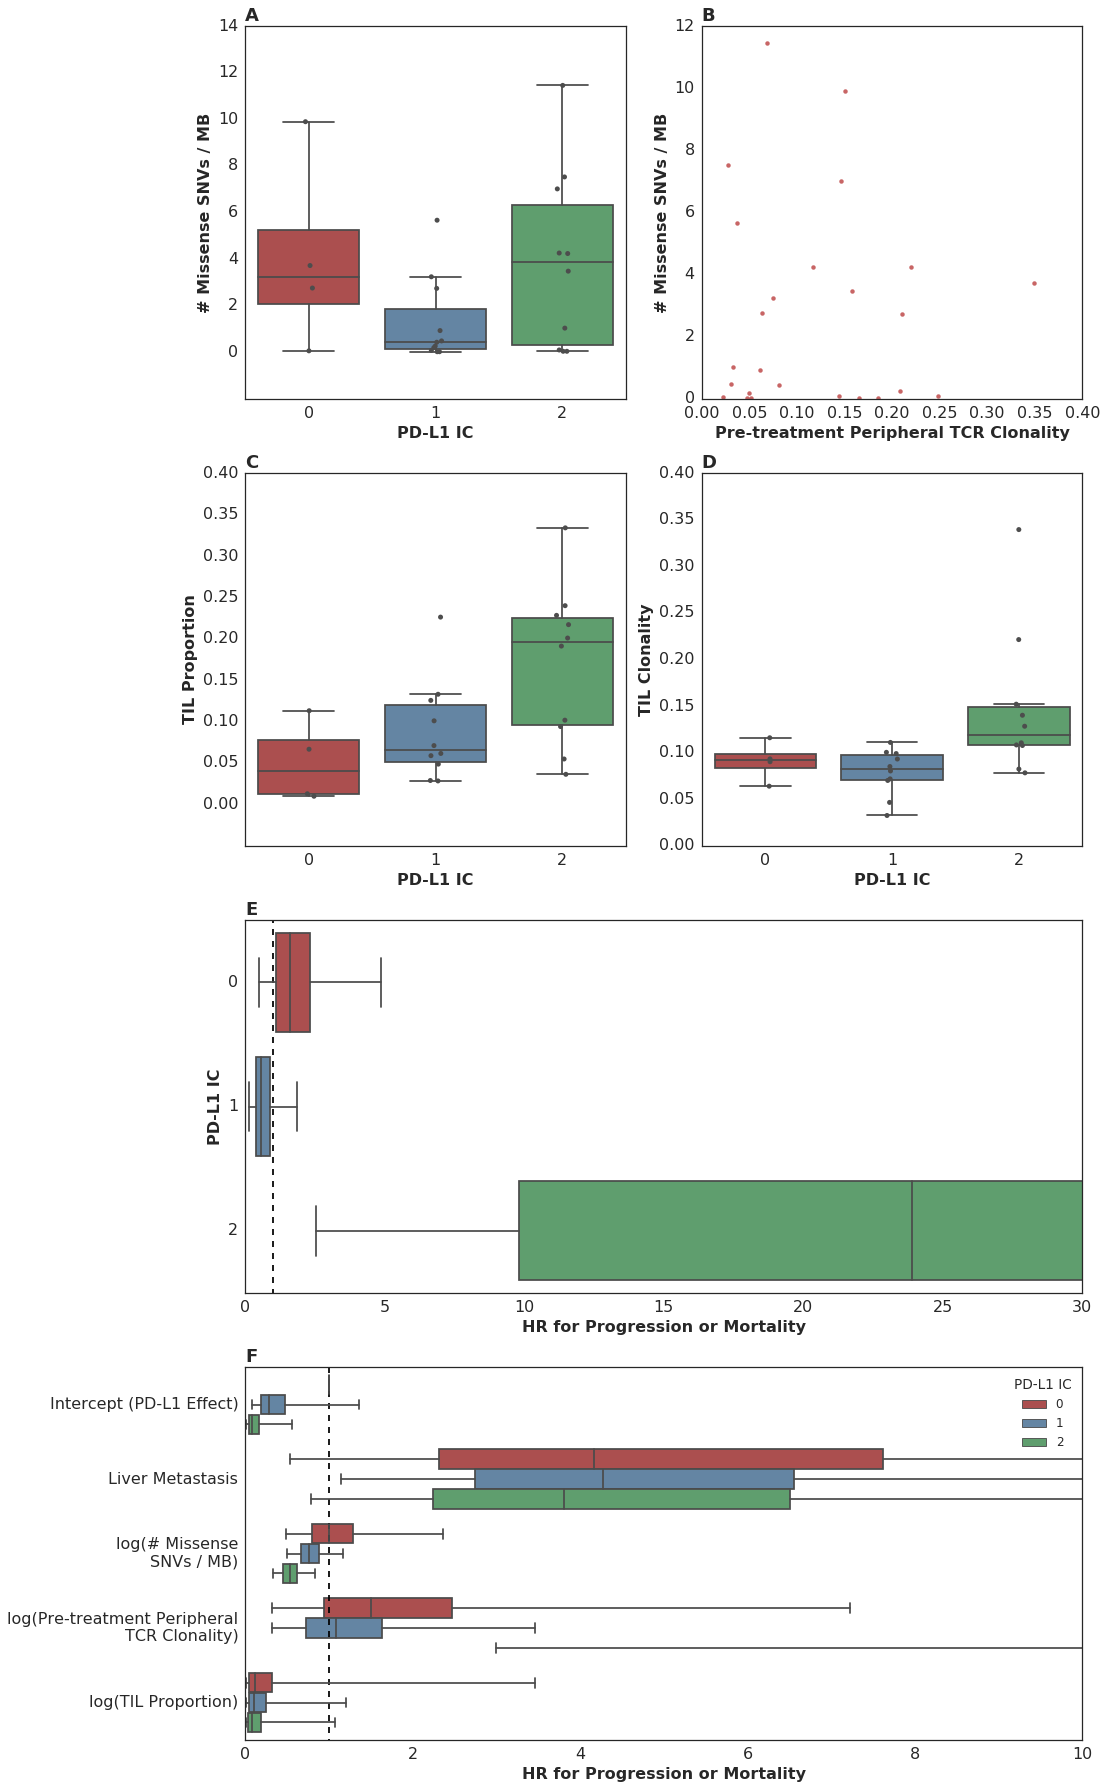

In [5]:
import matplotlib.gridspec as gridspec

fig = plt.figure()
gs1 = gridspec.GridSpec(4, 2)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])
ax3 = fig.add_subplot(gs1[2])
ax4 = fig.add_subplot(gs1[3])
ax5 = fig.add_subplot(gs1[4:6])
ax6 = fig.add_subplot(gs1[6:8])

fig.set_size_inches(2250 / 150, 2625 / 150)

title_loc = "left"
title_fontsize = 18
title_kwargs = {"loc": title_loc, "fontsize": title_fontsize, "fontweight": "bold"}

cohort = data.init_cohort()

cohort.plot_correlation({"PD-L1 IC": lambda row: int(row["PD-L1"].split("IC")[1]),
                                    "# Missense SNVs / MB": missense_snv_count},
                                    plot_type="boxplot",
                                    x_col="PD-L1 IC",
                                    plot_kwargs={"ax": ax1})
ax1.set_title("A", **title_kwargs)

cohort = data.init_cohort(join_with="tcr_peripheral_a")

results = cohort.plot_correlation({cohort.tcr_peripheral_a_clonality_plot_name: lambda row: 
                                                 row["Clonality"],
                                    "# Missense SNVs / MB": missense_snv_count},
                                    plot_type="regplot",
                                    x_col=cohort.tcr_peripheral_a_clonality_plot_name,
                                    plot_kwargs={"ax": ax2,
                                                 "fit_reg": False})
ax2.set_title("B", **title_kwargs)
results.plot.set_xlim((0, 0.4))
results.plot.set_ylim((0, 12))

cohort = data.init_cohort(join_with="tcr_tumor", 
                          exclude_patient_ids=set(),
                          only_patients_with_bams=False)

result = cohort.plot_correlation({"PD-L1 IC": lambda row: int(row["PD-L1"].split("IC")[1]),
                                    "TIL Proportion": 
                                      lambda row: row["T-cell fraction"]},
                                    plot_type="boxplot",
                                    x_col="PD-L1 IC",
                                    stat_func=spearmanr,
                                    plot_kwargs={"ax": ax3})
result.plot.set_xticklabels(["0", "1", "2"])
ax3.set_title("C", **title_kwargs)

result = cohort.plot_correlation({"PD-L1 IC": lambda row: int(row["PD-L1"].split("IC")[1]),
                                    "TIL Clonality": 
                                      lambda row: row["Clonality"]},
                                    plot_type="boxplot",
                                    x_col="PD-L1 IC",
                                    stat_func=spearmanr,
                                    plot_kwargs={"ax": ax4})
result.plot.set_xticklabels(["0", "1", "2"])
ax4.set_title("D", **title_kwargs)

def get_df_longs():
    cohort = data.init_cohort(join_with=["ensembl_coverage","tcr_peripheral_a"])

    def tcell_fraction(row):
        return row["T-cell fraction"]

    def peripheral_clonality_a(row):
        return row['Clonality']

    cols, d = cohort.as_dataframe([snv_count,
                                   missense_snv_count,
                                   neoantigen_count,
                                   expressed_exonic_snv_count,
                                   expressed_missense_snv_count,
                                   expressed_neoantigen_count,
                                   exonic_snv_count,
                                   peripheral_clonality_a,
                                   tcell_fraction,
                                   ],
                                  rename_cols=True,
                                  return_cols=True)

    ## add/modify count variables
    d['nonexonic_snv_count'] = d.snv_count - d.exonic_snv_count
    cols.append('nonexonic_snv_count')

    ## create 'observed', log-transformed & centered versions of variables (not normalized by MB)
    for col in cols:
        observed_col = 'observed_{}'.format(col)
        log_col = 'log_{}'.format(col)
        log_col_centered = 'log_{}_centered'.format(col)
        log_col_rescaled = 'log_{}_rescaled'.format(col)
        d[observed_col] = d[col]*d['mb']
        d[log_col] = np.log1p(d[observed_col])
        d[log_col_centered] = d[log_col] - np.mean(d[log_col])
        d[log_col_rescaled] = d[log_col_centered]/np.std(d[log_col_centered])

    ## save key vars in list for future use
    vars_centered = ['log_{}_centered'.format(col) for col in cols]
    vars_rescaled = ['log_{}_rescaled'.format(col) for col in cols]

    ## construct new variables for key ratios / comparisons

    # what proportion of X are expressed?
    d['exonic_expression_ratio'] = d.expressed_exonic_snv_count / d.exonic_snv_count
    d['missense_expression_ratio'] = d.expressed_missense_snv_count / d.missense_snv_count
    d['neoantigen_expression_ratio'] = d.expressed_neoantigen_count / d.neoantigen_count

    # d['expressed_missense2snv_ratio'] = d.expressed_missense_snv_count / d.expressed_snv_count
    d['missense2exonic_snv_ratio'] = d.missense_snv_count / d.exonic_snv_count
    d['expressed_neoantigen2missense_ratio'] = d.expressed_neoantigen_count / d.expressed_missense_snv_count

    extra_cols = ['missense_expression_ratio','neoantigen_expression_ratio', 'exonic_expression_ratio', 'missense2exonic_snv_ratio','expressed_neoantigen2missense_ratio']
    ## create recentered versions of ratios
    for col in extra_cols:
        col_centered = '{}_centered'.format(col)
        col_rescaled = '{}_rescaled'.format(col)
        d[col_centered] = d[col] - np.mean(d[col])
        d[col_rescaled] = d[col_centered]/np.std(d[col_centered])

    ## append extra-cols to key var lists
    vars_centered.extend(['{}_centered'.format(col) for col in extra_cols])
    vars_rescaled.extend(['{}_rescaled'.format(col) for col in extra_cols])

    ## identify list of variables to center
    metrics = list(cols)
    metrics.extend(extra_cols)

    metrics2 = list(metrics)
    metrics2.extend(['pd_l1'])
    assert(not 'pd_l1' in metrics)
    log_metrics2 = ['log_{}'.format(var) for var in metrics2]
    metrics2.extend(log_metrics2)

    grp_metrics = [var for var in metrics2 if var in d.columns]

    # center variables by group
    bygrp = d.loc[:, grp_metrics]
    bygrp = bygrp.groupby('pd_l1').transform(lambda x: x - x.mean())
    bygrp['patient_id'] = d.patient_id

    # merge recentered variables back into original dataframe
    df = pd.merge(d, bygrp, on = 'patient_id', suffixes = ['', '_centered_by_pd_l1'])

    ## prep dflong_pfs which will be used for survival analysis using stan
    df_long_pfs = survivalstan.prep_data_long_surv(df = df,
                                                   event_col = 'is_progressed_or_deceased',
                                                   time_col = 'pfs')
    df_long_os = survivalstan.prep_data_long_surv(df = df,
                                                   event_col = 'is_deceased',
                                                   time_col = 'os')
    return df_long_pfs, df_long_os

df_long_pfs, df_long_os = get_df_longs()

models = survivalstan.utils.read_files('../utils/stan')

survstan_pfs_varcoef = functools.partial(
    survivalstan.fit_stan_survival_model,
    df = df_long_pfs,
    model_code = models['pem_survival_model_unstructured_varcoef.stan'],
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    sample_col = 'patient_id',
    chains = 4,
    iter = 10000,
    grp_coef_type = 'vector-of-vectors',
    seed = seed,
    )
survstan_os_varcoef = functools.partial(
    survivalstan.fit_stan_survival_model,
    df = df_long_os,
    model_code = models['pem_survival_model_unstructured_varcoef.stan'],
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    sample_col = 'patient_id',
    chains = 4,
    iter = 10000,
    grp_coef_type = 'vector-of-vectors',
    seed = seed,
    )

tcrclonality_by_pdl1 = survstan_pfs_varcoef(formula = 'log_peripheral_clonality_a_centered_by_pd_l1', 
                               group_col = 'pd_l1',
                              )

result = sb.boxplot(ax=ax5, 
           data=tcrclonality_by_pdl1['grp_coefs'], x='exp(beta)', y='group', fliersize=0, whis=[2.5, 97.5])
_ = result.axes.set_xlim([0, 30])
_ = result.axes.set_yticklabels(["0", "1", "2"])
_ = result.axes.vlines(1, -10, 10, linestyles='--')
_ = result.axes.set_ylabel("PD-L1 IC")
_ = result.axes.set_xlabel('HR for {}'.format(cohort.hazard_plot_name))
ax5.set_title("E", **title_kwargs)

formula = 'liver_mets + {}_centered_by_pd_l1 + {}_centered_by_pd_l1 + {}_centered_by_pd_l1'.format(
    'log_missense_snv_count',
     'log_peripheral_clonality_a',
     'log_tcell_fraction',
    )
multivariate_models_varcoef = list()
multivariate_models_varcoef.append(survstan_pfs_varcoef(formula = formula,
                                                        model_cohort = formula,
                                                        group_col='pd_l1'))

## prep 'beta' coefficients for IC groups
## so that this can be communicated as well
grp_alpha = survivalstan.utils.extract_params_long([multivariate_models_varcoef[0]],
                                                   element='grp_alpha',
                                                   varnames = ['IC0','IC1','IC2'])
ic0_values = grp_alpha.loc[grp_alpha['variable']=='IC0',['iter','value','model_cohort']]
ic0_values.rename(columns={'value': 'ic0_value'}, inplace=True)
grp_alpha = grp_alpha.merge(ic0_values, on=['iter','model_cohort'])
grp_alpha['beta'] = grp_alpha.apply(lambda row: row['value'] - row['ic0_value'], axis=1)
grp_alpha['exp(beta)'] = np.exp(grp_alpha['beta'])
grp_alpha.drop('value', axis=1, inplace=True)
grp_alpha.rename(columns = {'variable': 'group', 'beta': 'value'}, inplace=True)
grp_alpha['variable'] = 'intercept'

all_coefs = pd.concat([grp_alpha, multivariate_models_varcoef[0]['grp_coefs']])

all_coefs['PD-L1 IC'] = all_coefs['group'].apply(lambda val: int(val[-1]))
result = sb.boxplot(ax=ax6,
           data = all_coefs,
           x = 'exp(beta)',
           y = 'variable',
           hue = 'PD-L1 IC',
           fliersize = 0,
           whis = [2.5, 97.5],
          )
_ = result.axes.set_xlim([0, 10])
_ = result.axes.set_ylabel('')
_ = result.axes.vlines(1, -10, 10, linestyles='--')
tcr_clonality_plot_name = cohort.tcr_peripheral_a_clonality_plot_name
tcr_c_p1 = " ".join(tcr_clonality_plot_name.split(" ")[:2])
tcr_c_p2 = " ".join(tcr_clonality_plot_name.split(" ")[2:])
tcr_clonality_plot_name = "\n".join([tcr_c_p1, tcr_c_p2])
_ = result.axes.set_yticklabels(
               ['Intercept (PD-L1 Effect)',
                'Liver Metastasis',
                'log(# Missense\nSNVs / MB)',
                'log({tcr_plot_name})'.format(tcr_plot_name=tcr_clonality_plot_name),
                'log({til_fraction_plot_name})'.format(til_fraction_plot_name=cohort.til_fraction_plot_name),
                ])
_ = result.axes.set_xlabel('HR for {}'.format(cohort.hazard_plot_name))
ax6.set_title("F", **title_kwargs)

plt.subplots_adjust(bottom=-0.5)

hyper_figure_label_printer("figure_mv")

fig.savefig(path.join(data.REPO_DATA_DIR, 'Fig4.tif'), format='tif', dpi=300, bbox_inches='tight')

In [6]:
from utils.paper import resize_image_plos
resize_image_plos("Fig4.tif", "Fig4.tif", figure_path=data.REPO_DATA_DIR)